In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from google.cloud import bigquery
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind, ttest_ind_from_stats
from sklearn.preprocessing import OneHotEncoder

In [2]:
client = bigquery.Client()

# Construct a reference to the "cms_medicare" dataset
medicare_dataset_reference = client.dataset("cms_medicare", project = "bigquery-public-data")

# Construct a reference to the "inpatient_charges_2015" table
table_ref = medicare_dataset_reference.table("inpatient_charges_2015")

# API request - fetch the table
table = client.get_table(table_ref)
med_columns = client.list_rows(table, selected_fields = table.schema[:]).to_dataframe()

df = pd.DataFrame(med_columns, columns = ["provider_state", "drg_definition", "average_total_payments", "average_medicare_payments"])

df = df.dropna()

Using Kaggle's public dataset BigQuery integration.


In [3]:
# Drop the rows of the data table containing states outside of New England
indexNames = df[(df["provider_state"] != "NH") & (df["provider_state"] != "MA") & (df["provider_state"] != "ME") & (df["provider_state"] != "VT") & (df["provider_state"] != "RI") & (df["provider_state"] != "CT")].index
df.drop(indexNames, inplace=True)

# Drop the rows of the data table containing drugs different than the selected ones
indexNames = df[(df["drg_definition"] != "292 - HEART FAILURE & SHOCK W CC") & (df["drg_definition"] != "194 - SIMPLE PNEUMONIA & PLEURISY W CC") & (df["drg_definition"] != "191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC")].index
df.drop(indexNames, inplace=True)

In [4]:
labelencoder = LabelEncoder()
dfLabel = df.copy(deep = True)

# Label Encode New England states
dfLabel['provider_state_cat'] = labelencoder.fit_transform(dfLabel['provider_state'])

# Label Encode conditions
dfLabel['drg_definition_cat'] = labelencoder.fit_transform(dfLabel['drg_definition'])

# Drop the "provider_state" and "drg_definition" column
cleanDFL = dfLabel.drop(["provider_state"], axis=1)
cleanDFL = dfLabel.drop(["drg_definition"], axis=1)

In [5]:
# One Hot Encode the New England states to account for them being categorical
df_clean = pd.get_dummies(df["provider_state"])
df = pd.concat([df, df_clean], axis = 1)

# One Hot Encode the conditions to account for them being categorical
df_clean = pd.get_dummies(df["drg_definition"])
df = pd.concat([df, df_clean], axis = 1)

# Rename conditions
df = df.rename(columns = {"292 - HEART FAILURE & SHOCK W CC": "heart_failure_and_shock", "194 - SIMPLE PNEUMONIA & PLEURISY W CC": "simple_pneumonia_and_pleurisy", "191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC": "chronic_obstructive_pulmonary_disease"})

# Drop the "provider_state" and "drg_definition" column
cleanDF = df.drop(["provider_state"], axis=1)
cleanDF = df.drop(["drg_definition"], axis=1)

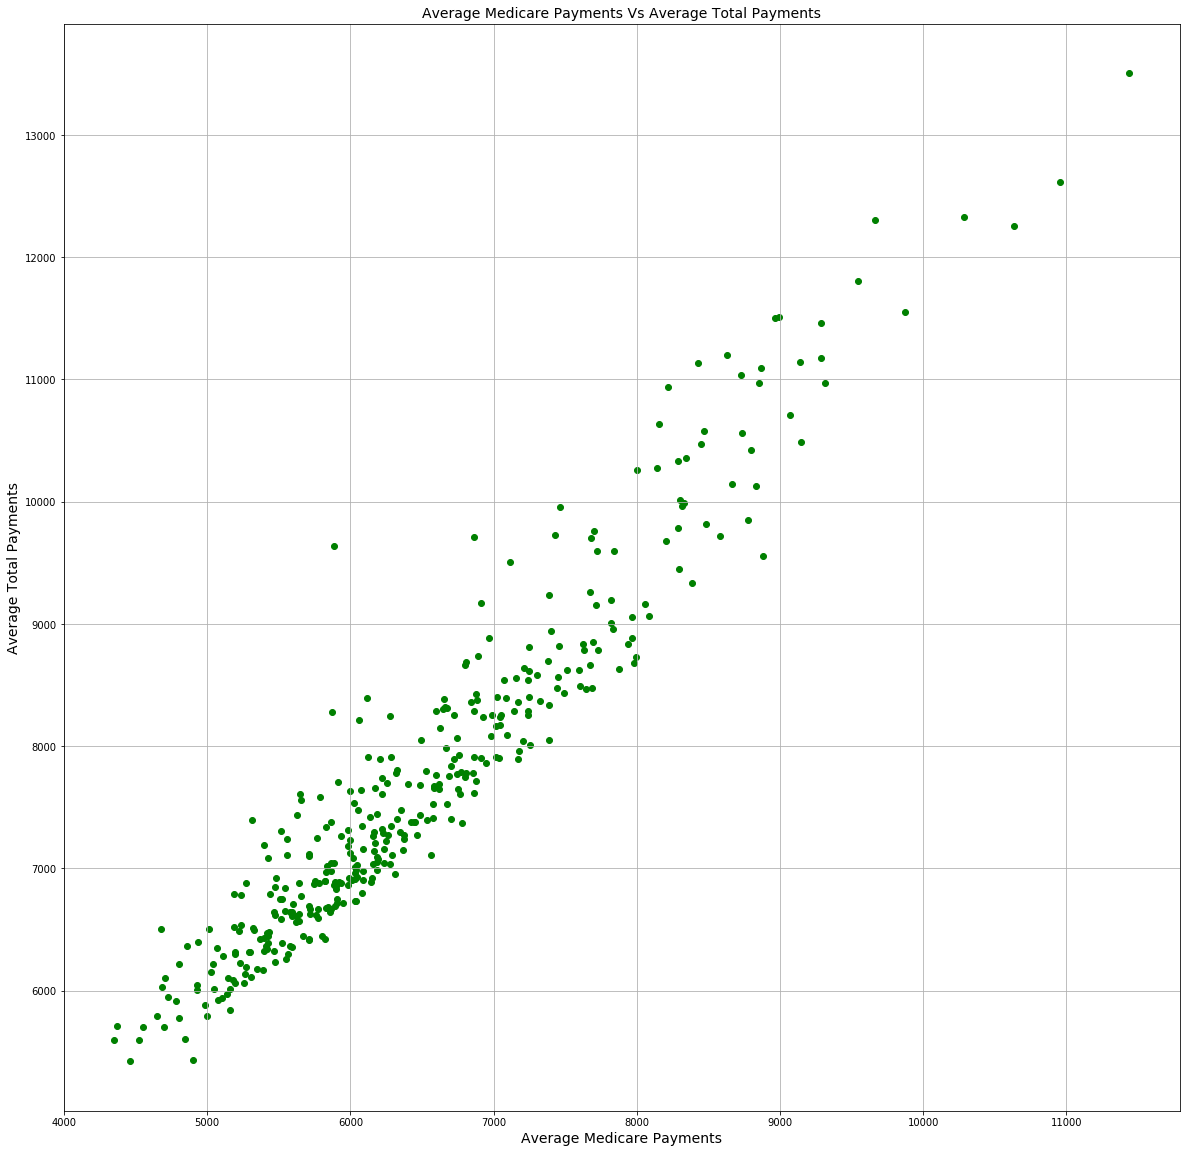

In [6]:
plt.figure(figsize = (20, 20))
plt.scatter(df["average_medicare_payments"], df["average_total_payments"], color = "green")
plt.title("Average Medicare Payments Vs Average Total Payments", fontsize = 14)
plt.xlabel("Average Medicare Payments", fontsize = 14)
plt.ylabel("Average Total Payments", fontsize = 14)
plt.grid(True)
plt.show()

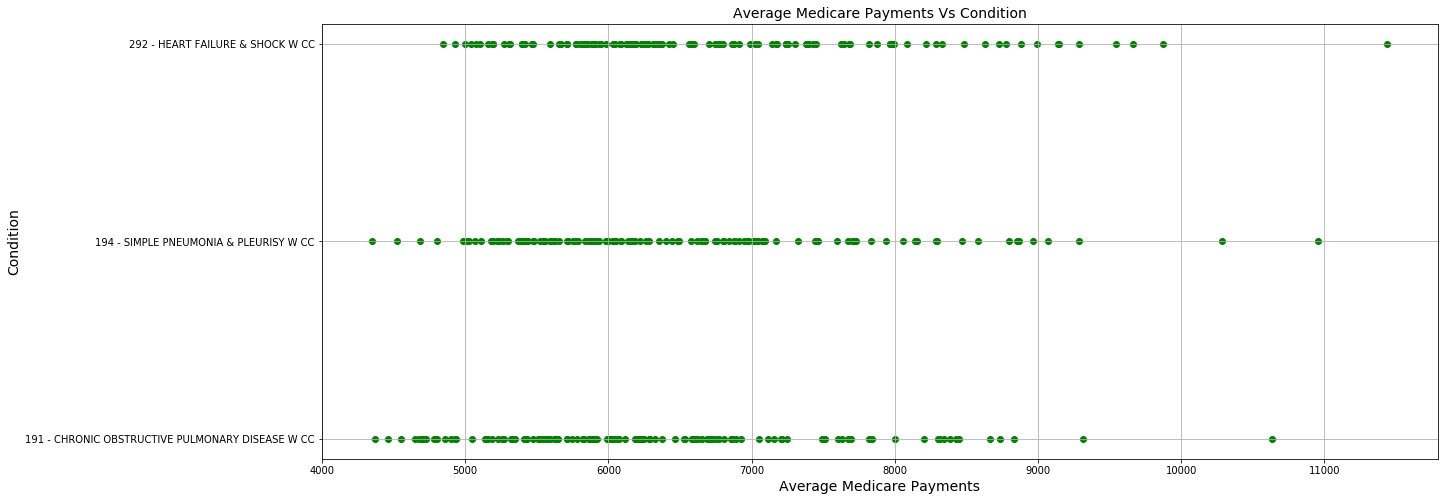

In [7]:
plt.figure(figsize = (20, 8))
plt.scatter(df["average_medicare_payments"], df["drg_definition"], color = "green")
plt.title('Average Medicare Payments Vs Condition', fontsize = 14)
plt.xlabel('Average Medicare Payments', fontsize = 14)
plt.ylabel('Condition', fontsize = 14)
plt.grid(True)
plt.show()

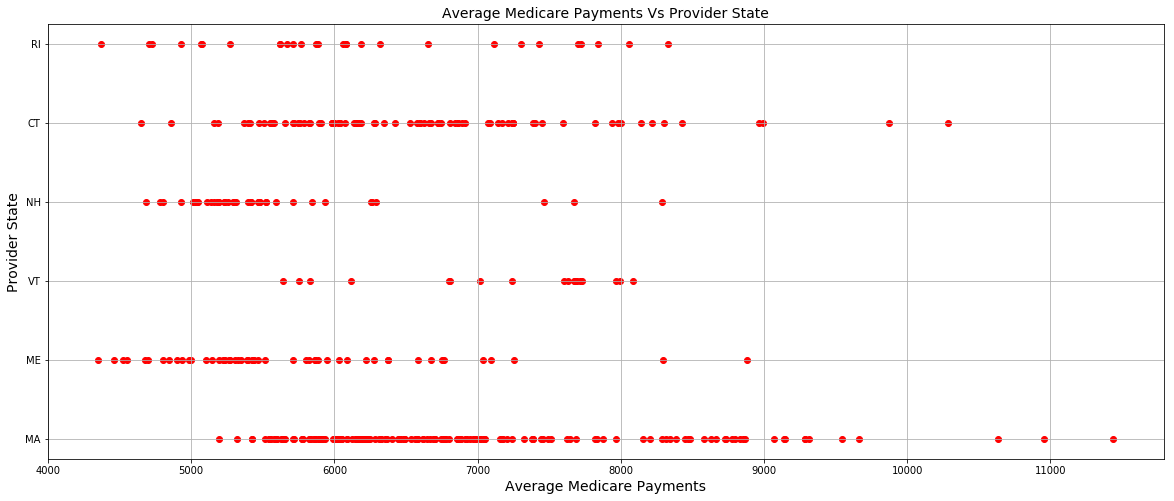

In [8]:
plt.figure(figsize = (20, 8))
plt.scatter(df["average_medicare_payments"], df["provider_state"], color = "red")
plt.title("Average Medicare Payments Vs Provider State", fontsize = 14)
plt.xlabel("Average Medicare Payments", fontsize = 14)
plt.ylabel("Provider State", fontsize = 14)
plt.grid(True)
plt.show()

# Regression for One Hot Encoding Data

In [9]:
# split dataset into training set and test set
Y = cleanDF["average_medicare_payments"]
X = cleanDF.drop(["average_medicare_payments"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

xtrain = pd.DataFrame(X_train)
ytrain = pd.DataFrame(y_train)
trainFrame = [ytrain, xtrain]
train = pd.concat(trainFrame, axis = 1)

allReg = smf.ols(formula = 'average_medicare_payments ~ average_total_payments + CT + MA + ME + NH + RI + VT + chronic_obstructive_pulmonary_disease + heart_failure_and_shock + simple_pneumonia_and_pleurisy', data=train).fit()

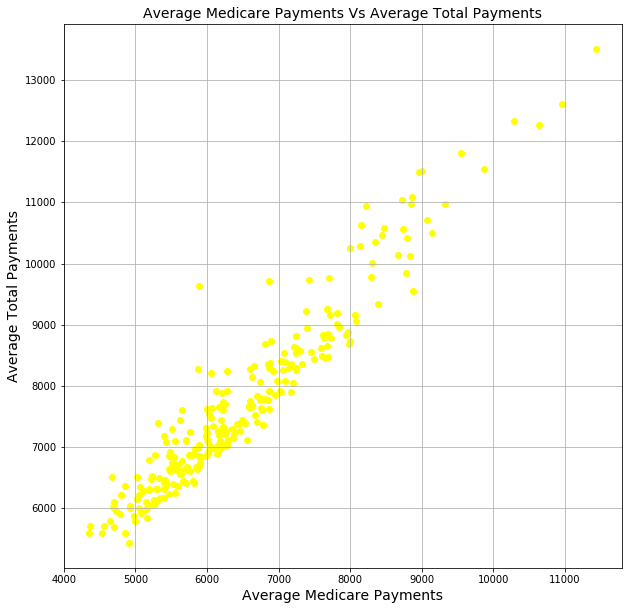

In [10]:
plt.figure(figsize = (10, 10))
plt.scatter(train["average_medicare_payments"], train["average_total_payments"], color = "yellow")
plt.title("Average Medicare Payments Vs Average Total Payments", fontsize = 14)
plt.xlabel("Average Medicare Payments", fontsize = 14)
plt.ylabel("Average Total Payments", fontsize = 14)
plt.grid(True)
plt.show()

In [11]:
allReg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     average_medicare_payments   R-squared:                       0.930
Model:                                   OLS   Adj. R-squared:                  0.928
Method:                        Least Squares   F-statistic:                     424.3
Date:                       Fri, 06 Mar 2020   Prob (F-statistic):          1.32e-142
Time:                               00:37:29   Log-Likelihood:                -1907.6
No. Observations:                        264   AIC:                             3833.
Df Residuals:                            255   BIC:                             3865.
Df Model:                                  8                                         
Covariance Type:                   nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                               288.8398     80.556      3.586      0.000     130.199     447.480
average_total_payments                    0.7823      0.016     50.027      0.000       0.751       0.813
CT                                      -22.1420     47.085     -0.470      0.639    -114.867      70.583
MA                                      184.7151     43.636      4.233      0.000      98.783     270.648
ME                                      -16.7319     51.561     -0.325      0.746    -118.272      84.808
NH                                      -59.5937     55.201     -1.080      0.281    -168.302      49.114
RI                                     -184.6671     68.016     -2.715      0.007    -318.612     -50.722
VT                                      387.2595     86.360      4.484      0.000     217.190     557.329
chronic_obstructive_pulmonary_disease    51.4127     37.824      1.359      0.175     -23.075     125.901
heart_failure_and_shock                 183.0975     40.690      4.500      0.000     102.967     263.228
simple_pneumonia_and_pleurisy            54.3296     41.444      1.311      0.191     -27.287     135.947
==============================================================================
Omnibus:                       88.706   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              442.855
Skew:                          -1.267   Prob(JB):                     6.84e-97
Kurtosis:                       8.817   Cond. No.                     8.73e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.13e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [12]:
anova_results = anova_lm(allReg)
display(anova_results)

,df,sum_sq,mean_sq,F,PR(>F)
average_total_payments,1.0,3.829828e+08,3.829828e+08,3345.530598,1.291843e-148
CT,1.0,6.326063e+05,6.326063e+05,5.526106,1.949689e-02
MA,1.0,1.278185e+06,1.278185e+06,11.165530,9.581912e-04
ME,1.0,1.606854e+01,1.606854e+01,0.000140,9.905565e-01
NH,1.0,1.225056e+05,1.225056e+05,1.070142,3.018934e-01
RI,1.0,2.529905e+06,2.529905e+06,22.099881,4.240450e-06
VT,1.0,6.783197e+04,6.783197e+04,0.592543,4.421498e-01
chronic_obstructive_pulmonary_disease,1.0,3.014105e+05,3.014105e+05,2.632959,1.059021e-01
heart_failure_and_shock,1.0,7.221911e+05,7.221911e+05,6.308671,1.263355e-02
simple_pneumonia_and_pleurisy,1.0,2.580797e+05,2.580797e+05,2.254445,1.344684e-01


# Assumptions for One Hot Encoding Data Regression

Assumption 1: Linear in Response


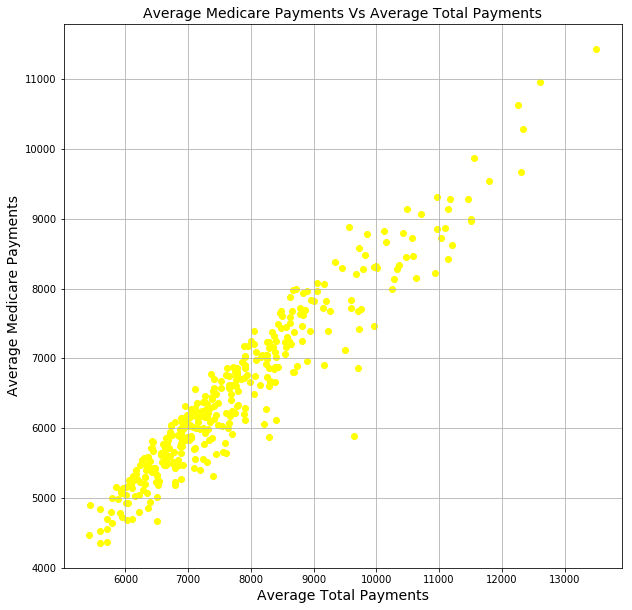

In [13]:
predictions = allReg.predict(X_test)

print("Assumption 1: Linear in Response")

plt.figure(figsize = (10, 10))
plt.scatter(cleanDF["average_total_payments"], cleanDF["average_medicare_payments"], color = "yellow")
plt.title("Average Medicare Payments Vs Average Total Payments", fontsize = 14)
plt.xlabel("Average Total Payments", fontsize = 14)
plt.ylabel("Average Medicare Payments", fontsize = 14)
plt.grid(True)
plt.show()

Assumption 2: Normal Distribution of Error Terms


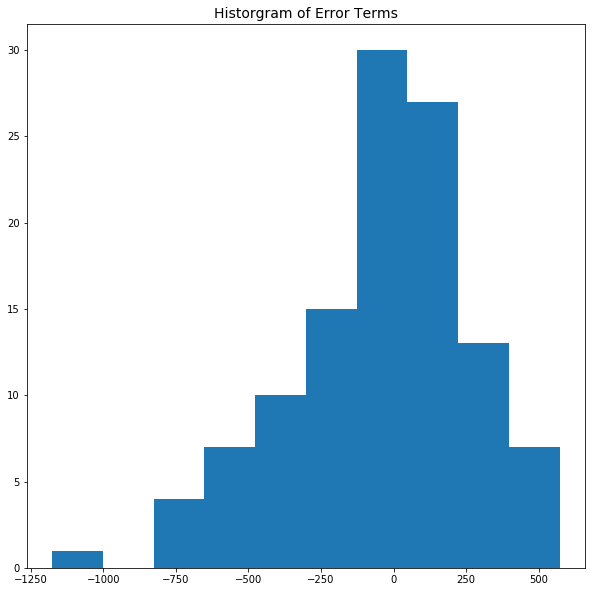

<Figure size 720x720 with 0 Axes>

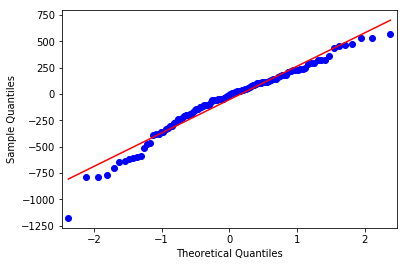

In [14]:
residuals = y_test - predictions

print("Assumption 2: Normal Distribution of Error Terms")
plt.figure(figsize = (10, 10))
plt.hist(residuals)
plt.title("Historgram of Error Terms", fontsize = 14)
plt.show()

plt.figure(figsize = (10, 10))
qqplot(residuals, line='s')
plt.show()

Assumption 3: Little to No Multicollinearity Amongst Predictors


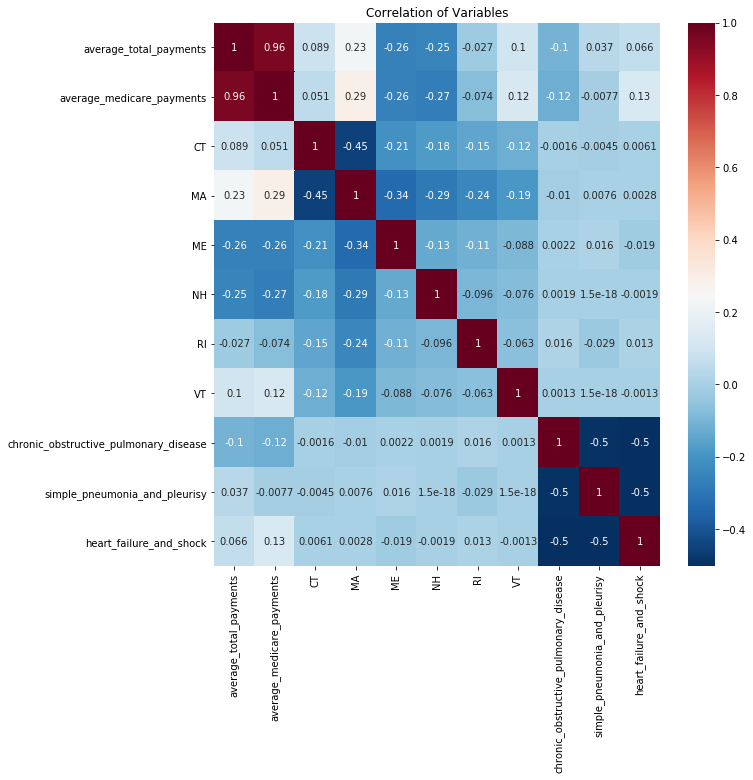

In [15]:
print("Assumption 3: Little to No Multicollinearity Amongst Predictors")
plt.figure(figsize = (10, 10))
sns.heatmap(cleanDF.corr(), annot = True, cmap = "RdBu_r")
plt.title('Correlation of Variables')
plt.show()

Assumption 4: Homoscedasticity of Error Terms


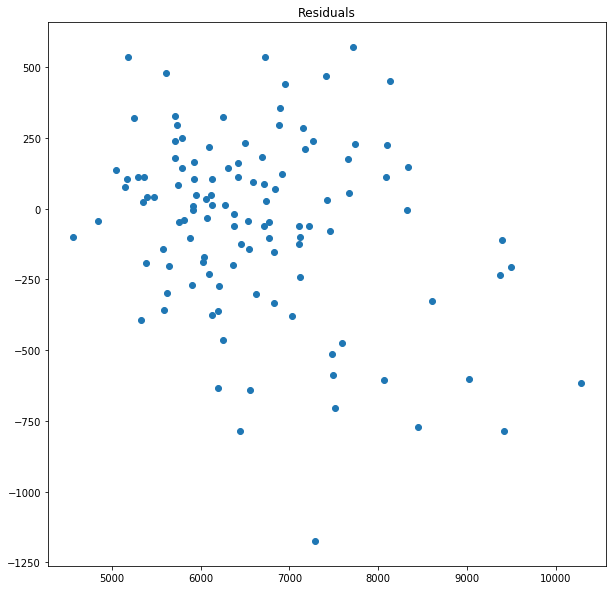

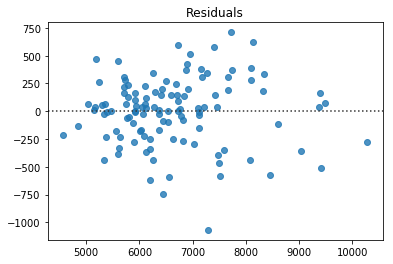

In [16]:
print("Assumption 4: Homoscedasticity of Error Terms")
plt.figure(figsize = (10, 10))
plt.scatter(predictions, residuals)
plt.title('Residuals')
plt.show()

sns.residplot(predictions, residuals)
plt.title("Residuals")
plt.show()

# Model for the Label Encoded Data

In [17]:
# split dataset into training set and test set
YLabel = dfLabel["average_medicare_payments"]
XLabel = dfLabel.drop(["average_medicare_payments"], axis = 1)

XL_train, XL_test, yl_train, yl_test = train_test_split(XLabel, YLabel, test_size=0.3)

xltrain = pd.DataFrame(XL_train)
yltrain = pd.DataFrame(yl_train)
trainLFrame = [yltrain, xltrain]
trainL = pd.concat(trainLFrame, axis = 1)

allRegL = smf.ols(formula = 'average_medicare_payments ~ provider_state_cat +  drg_definition_cat + provider_state_cat:drg_definition_cat', data = trainL).fit()

In [18]:
allRegL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     average_medicare_payments   R-squared:                       0.049
Model:                                   OLS   Adj. R-squared:                  0.038
Method:                        Least Squares   F-statistic:                     4.426
Date:                       Fri, 06 Mar 2020   Prob (F-statistic):            0.00469
Time:                               00:37:33   Log-Likelihood:                -2243.0
No. Observations:                        264   AIC:                             4494.
Df Residuals:                            260   BIC:                             4508.
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                              6596.4613    170.307     38.733      0.000    6261.105    6931.818
provider_state_cat                     -196.8564     87.721     -2.244      0.026    -369.591     -24.122
drg_definition_cat                      145.6188    133.360      1.092      0.276    -116.984     408.221
provider_state_cat:drg_definition_cat    46.4022     68.479      0.678      0.499     -88.442     181.246
==============================================================================
Omnibus:                       47.696   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.340
Skew:                           1.115   Prob(JB):                     8.77e-16
Kurtosis:                       4.154   Cond. No.                         9.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
anovaLabelResults = anova_lm(allRegL)
display(anovaLabelResults)

,df,sum_sq,mean_sq,F,PR(>F)
provider_state_cat,1.0,1.021919e+07,1.021919e+07,7.172811,0.007873
drg_definition_cat,1.0,8.044837e+06,8.044837e+06,5.646642,0.018214
provider_state_cat:drg_definition_cat,1.0,6.541694e+05,6.541694e+05,0.459159,0.498620
Residual,260.0,3.704250e+08,1.424712e+06,NaN,NaN


# t-Tests for Differences Between States for Each Condition

In [20]:
cop = cleanDF[cleanDF['chronic_obstructive_pulmonary_disease'] == 1] 
pnp = cleanDF[cleanDF['simple_pneumonia_and_pleurisy'] == 1] 
hfs = cleanDF[cleanDF['heart_failure_and_shock'] == 1] 

In [21]:
cop_MA = cop[cop['MA'] == 1] 
cop_CT = cop[cop['CT'] == 1]
cop_ME = cop[cop['ME'] == 1]
cop_NH = cop[cop['NH'] == 1]
cop_RI = cop[cop['RI'] == 1]
cop_VT = cop[cop['VT'] == 1]


t1, p1 = ttest_ind(cop_MA["average_medicare_payments"], cop_CT["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 6.770575647837694e-07, t: 5.742239249536845)
t2, p2 = ttest_ind(cop_MA["average_medicare_payments"], cop_ME["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 3.279788424924026e-05, t: 4.949946655118951)
t3, p3 = ttest_ind(cop_MA["average_medicare_payments"], cop_NH["average_medicare_payments"], equal_var=False) 

# significantly different (p-value: 0.03752753320166308, t: 2.311229809022888)
t4, p4 = ttest_ind(cop_MA["average_medicare_payments"], cop_RI["average_medicare_payments"], equal_var=False) 

t5, p5 = ttest_ind(cop_MA["average_medicare_payments"], cop_VT["average_medicare_payments"], equal_var=False) 



# significantly different (p-value: 0.0003520152379164334, t: 3.9012564548409636)
t6, p6 = ttest_ind(cop_CT["average_medicare_payments"], cop_ME["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 0.002110864710101813, t: 3.383173055051486)
t7, p7 = ttest_ind(cop_CT["average_medicare_payments"], cop_NH["average_medicare_payments"], equal_var=False)

t8, p8 = ttest_ind(cop_CT["average_medicare_payments"], cop_RI["average_medicare_payments"], equal_var=False)

t9, p9 = ttest_ind(cop_CT["average_medicare_payments"], cop_VT["average_medicare_payments"], equal_var=False)



t10, p10 = ttest_ind(cop_ME["average_medicare_payments"], cop_NH["average_medicare_payments"], equal_var=False)

t11, p11 = ttest_ind(cop_ME["average_medicare_payments"], cop_RI["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 0.0060613340861584986, t: -3.7971246067845237)
t12, p12 = ttest_ind(cop_ME["average_medicare_payments"], cop_VT["average_medicare_payments"], equal_var=False)



t13, p13 = ttest_ind(cop_NH["average_medicare_payments"], cop_RI["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 0.006339733193515463, t: -3.560522556610264)
t14, p14 = ttest_ind(cop_NH["average_medicare_payments"], cop_VT["average_medicare_payments"], equal_var=False)



t15, p15 = ttest_ind(cop_RI["average_medicare_payments"], cop_VT["average_medicare_payments"], equal_var=False)

In [22]:
pnp_MA = pnp[pnp['MA'] == 1] 
pnp_CT = pnp[pnp['CT'] == 1]
pnp_ME = pnp[pnp['ME'] == 1]
pnp_NH = pnp[pnp['NH'] == 1]
pnp_RI = pnp[pnp['RI'] == 1]
pnp_VT = pnp[pnp['VT'] == 1]


t1, p1 = ttest_ind(pnp_MA["average_medicare_payments"], pnp_CT["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 0.0006555434213803764, t: 3.7457831451355106)
t2, p2 = ttest_ind(pnp_MA["average_medicare_payments"], pnp_ME["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 7.993088245425334e-06, t: 5.333123020386997)
t3, p3 = ttest_ind(pnp_MA["average_medicare_payments"], pnp_NH["average_medicare_payments"], equal_var=False) 

t4, p4 = ttest_ind(pnp_MA["average_medicare_payments"], pnp_RI["average_medicare_payments"], equal_var=False) 

t5, p5 = ttest_ind(pnp_MA["average_medicare_payments"], pnp_VT["average_medicare_payments"], equal_var=False) 



# significantly different (p-value: 0.007257921175918495, t: 2.830314679738243)
t6, p6 = ttest_ind(pnp_CT["average_medicare_payments"], pnp_ME["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 0.00025872527846303525, t: 4.0577870521999175)
t7, p7 = ttest_ind(pnp_CT["average_medicare_payments"], pnp_NH["average_medicare_payments"], equal_var=False)

t8, p8 = ttest_ind(pnp_CT["average_medicare_payments"], pnp_RI["average_medicare_payments"], equal_var=False)

t9, p9 = ttest_ind(pnp_CT["average_medicare_payments"], pnp_VT["average_medicare_payments"], equal_var=False)



t10, p10 = ttest_ind(pnp_ME["average_medicare_payments"], pnp_NH["average_medicare_payments"], equal_var=False)

t11, p11 = ttest_ind(pnp_ME["average_medicare_payments"], pnp_RI["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 0.005153862947893044, t: -3.4683016471740786)
t12, p12 = ttest_ind(pnp_ME["average_medicare_payments"], pnp_VT["average_medicare_payments"], equal_var=False)



# significantly different (p-value: 0.043131020197571326 , t: -2.305539493394235)
t13, p13 = ttest_ind(pnp_NH["average_medicare_payments"], pnp_RI["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 0.00163809255759687, t: -4.438605871709585)
t14, p14 = ttest_ind(pnp_NH["average_medicare_payments"], pnp_VT["average_medicare_payments"], equal_var=False)



t15, p15 = ttest_ind(pnp_RI["average_medicare_payments"], pnp_VT["average_medicare_payments"], equal_var=False)

In [23]:
hfs_MA = hfs[hfs['MA'] == 1] 
hfs_CT = hfs[hfs['CT'] == 1]
hfs_ME = hfs[hfs['ME'] == 1]
hfs_NH = hfs[hfs['NH'] == 1]
hfs_RI = hfs[hfs['RI'] == 1]
hfs_VT = hfs[hfs['VT'] == 1]


t1, p1 = ttest_ind(hfs_MA["average_medicare_payments"], hfs_CT["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 0.000755707761812567, t:3.7563735014753927)
t2, p2 = ttest_ind(hfs_MA["average_medicare_payments"], hfs_ME["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 5.693977062654307e-05, t: 4.775506982343496)
t3, p3 = ttest_ind(hfs_MA["average_medicare_payments"], hfs_NH["average_medicare_payments"], equal_var=False) 

# significantly different (p-value: 0.04415831983699919, t: 2.2209363807736278)
t4, p4 = ttest_ind(hfs_MA["average_medicare_payments"], hfs_RI["average_medicare_payments"], equal_var=False) 

t5, p5 = ttest_ind(hfs_MA["average_medicare_payments"], hfs_VT["average_medicare_payments"], equal_var=False) 



# significantly different (p-value: 0.01739811561716252, t: 2.500319590791419)
t6, p6 = ttest_ind(hfs_CT["average_medicare_payments"], hfs_ME["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 0.0022136095592824334, t: 3.3353652033163455)
t7, p7 = ttest_ind(hfs_CT["average_medicare_payments"], hfs_NH["average_medicare_payments"], equal_var=False)

t8, p8 = ttest_ind(hfs_CT["average_medicare_payments"], hfs_RI["average_medicare_payments"], equal_var=False)

t9, p9 = ttest_ind(hfs_CT["average_medicare_payments"], hfs_VT["average_medicare_payments"], equal_var=False)



t10, p10 = ttest_ind(hfs_ME["average_medicare_payments"], hfs_NH["average_medicare_payments"], equal_var=False)

t11, p11 = ttest_ind(hfs_ME["average_medicare_payments"], hfs_RI["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 0.005824442772354522, t: -3.4401232534571977)
t12, p12 = ttest_ind(hfs_ME["average_medicare_payments"], hfs_VT["average_medicare_payments"], equal_var=False)




t13, p13 = ttest_ind(hfs_NH["average_medicare_payments"], hfs_RI["average_medicare_payments"], equal_var=False)

# significantly different (p-value: 0.002563927537492345 , t: -4.063974487404295)
t14, p14 = ttest_ind(hfs_NH["average_medicare_payments"], hfs_VT["average_medicare_payments"], equal_var=False)



# significantly different (p-value: 0.029730927767202153 , t: -2.442509170411169)
t15, p15 = ttest_ind(hfs_RI["average_medicare_payments"], hfs_VT["average_medicare_payments"], equal_var=False)